### Configuration

In [65]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, Trainer
from torch.utils.data import Dataset, DataLoader
from multiprocessing import Pool
from functools import partial
from torch.nn import Softmax
import warnings
warnings.filterwarnings("ignore")

TEST_RATIO = 0.1 
MASTER_SEED = 42
MODEL_ID = 1
MODELS = (
    'klue/roberta-base', # 0
    'klue/roberta-large', # 1
    'klue/bert-base', # 2
    'monologg/koelectra-base-v3-discriminator' # 3    
)
MODEL_NAME = MODELS[MODEL_ID]
BATCH_SZIE = 50
REPETITIONS = 50
torch.cuda.is_available()

True

- Loading Preprocess Youtube Data

In [2]:
youtube_df = pd.read_csv('../data/youtube_process/preprocess_youtube_df.csv', encoding='utf-8-sig',lineterminator='\n')
youtube_df = youtube_df[['publishedAt','videoTitle','clean_text']]
youtube_df.dropna(inplace=True)
youtube_df = youtube_df.reset_index()
youtube_df.head()

,publishedAt,videoTitle,clean_text
0,2020-08-01T07:32:13Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,기상청 날씨하나 맞추는게 어렵니
1,2020-07-31T10:41:35Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,뭔 뉴스에 광고가 이리도 많나요 징허네 진짜
2,2020-07-31T09:59:54Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,잠금만 풀면되지 왜 오래들고 있냐증거물 없애려고 그러는거 아냐
3,2020-07-31T09:47:32Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,한똥훈 니 말을 어떻게 믿냐 미꾸라지 같어
4,2020-07-31T09:07:38Z,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,이슬비 보슬비 가랑비에호들갑


- Loading Saving Model

In [3]:
model_path = '../Sentiment_Analysis/output/further_pretrain_robert-large_20240619_173057/checkpoint-45345' # futther RoBERTa-large
model = AutoModelForSequenceClassification.from_pretrained(model_path,device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)
collator = DataCollatorWithPadding(tokenizer)

### Inference Youtube Data Sentiment

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference_texts = youtube_df['clean_text'].tolist()

batch_size = 100 # 한번에 처리할 데이터 수
batch_li = []
temp_li = []
prediction_results = []

for idx, text in enumerate(inference_texts):
    temp_li.append(text)
    if len(temp_li) == batch_size or idx == len(inference_texts) - 1:
        batch_li.append(temp_li)
        temp_li = []
        
for text_batch in tqdm(batch_li):
    # Tokenize and prepare input
    inference_encodings = tokenizer(text_batch, truncation=True, padding=True, return_tensors="pt")
    input_data = {key: tensor.to(device) for key, tensor in inference_encodings.items()}
    # Perform inference
    with torch.no_grad():
        model.eval()
        outputs = model(**input_data)
    # Calculate probabilities
    probabilities = torch.softmax(outputs.logits, dim=1).tolist()
    # Extract predicted labels
    predictions = outputs.logits.argmax(dim=1).tolist()
    sentiment_map = {0: 'happy', 1: 'angry', 2: 'sad', 3: 'neutral'}
    prediction_label = [sentiment_map[prediction] for prediction in predictions]
    # Combine labels with probabilities
    for i in range(len(text_batch)):
        result = {
            'Text': text_batch[i],
            'Top_Sentiment': prediction_label[i],
            'Prob_Happy': probabilities[i][0],
            'Prob_Angry': probabilities[i][1],
            'Prob_Sad': probabilities[i][2],
            'Prob_Neutral': probabilities[i][3]
        }
        prediction_results.append(result)

100%|██████████| 31072/31072 [14:00:33<00:00,  1.62s/it]  


In [ ]:
inference_df = pd.DataFrame(prediction_results)
inference_df = pd.concat([youtube_df, inference_df], axis=1)
inference_df['Mental_index_score'] = (inference_df['Prob_Happy'] * +1) + (inference_df['Prob_Angry'] * -1) + (inference_df['Prob_Sad'] * -1) + (inference_df['Prob_Neutral'] * 0)
inference_df

In [52]:
inference_df[inference_df['Top_Sentiment'] == 'angry'][['Text','Top_Sentiment','Prob_Happy','Prob_Angry','Prob_Sad','Prob_Neutral','Mental_index_score']]
# inference_df.to_csv('../data/youtube_inference/inference_youtube_sentiment.csv',index=False,encoding='utf-8-sig')

,Text,Top_Sentiment,Prob_Happy,Prob_Angry,Prob_Sad,Prob_Neutral,Mental_index_score
1,뭔 뉴스에 광고가 이리도 많나요 징허네 진짜,angry,0.000007,0.999970,0.000021,0.000002,-0.999983
5,한동훈 조전장관님은 죄도없는데무조건입건하고 전화기는마음대로빼서가잔아 구런데왜전화기자...,angry,0.000003,0.999988,0.000008,0.000001,-0.999994
8,민주당법안 개속밀고가세요,angry,0.000005,0.999969,0.000023,0.000003,-0.999988
11,기자 오가지네 엄청 버벅되네,angry,0.000007,0.999969,0.000021,0.000003,-0.999983
12,4대강 없어으면 대홍수 있었을건데 4대강있는대는 안나잖아 그런대도 나쁜 남즐은 4댜...,angry,0.000004,0.999983,0.000010,0.000003,-0.999989
...,...,...,...,...,...,...,...
3107120,홍남기야2천조원 이란다,angry,0.024941,0.898841,0.062121,0.014098,-0.936021
3107123,2분지점부터가 뉴스이전은 광고,angry,0.000022,0.999802,0.000152,0.000023,-0.999932
3107124,부정선거 입니다 이번에는 꼭 밝혀야 합니다 윤석열 총장님 국회의원님들 나서 주세요...,angry,0.000014,0.999950,0.000029,0.000007,-0.999965
3107126,부럽다우린아직도문닫고있는데,angry,0.000008,0.999947,0.000041,0.000004,-0.999980


- Distribution of Mental Health Index

In [66]:
inference_df = pd.read_csv('../data/youtube_inference/inference_youtube_sentiment.csv',lineterminator='\n')

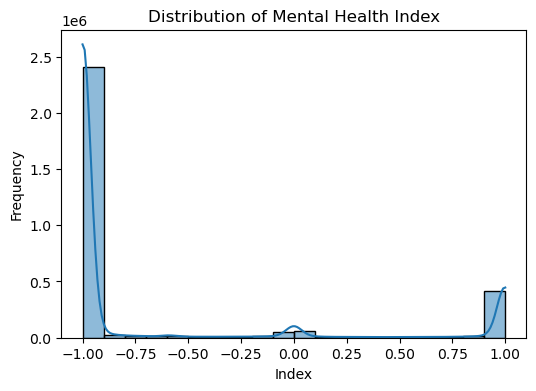

In [67]:
plt.figure(figsize=(6, 4))
sns.histplot(inference_df['Mental_index_score'], kde=True, bins=20)
plt.title('Distribution of Mental Health Index')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.show()

### Checking Sentiment Distribution

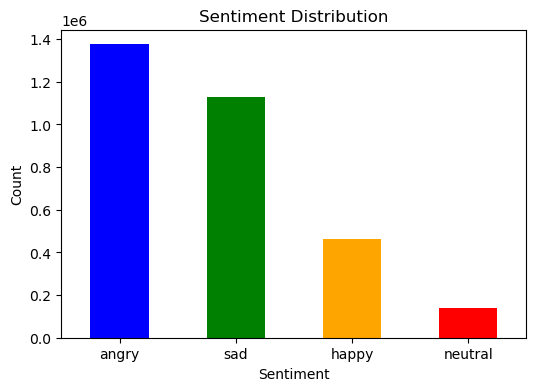

In [69]:
inference_df['sentiment_happy'] = inference_df['Top_Sentiment'].apply(lambda x: 1 if x == 'happy' else 0)
inference_df['sentiment_sad'] = inference_df['Top_Sentiment'].apply(lambda x: 1 if x == 'sad' else 0)
inference_df['sentiment_angry'] = inference_df['Top_Sentiment'].apply(lambda x: 1 if x == 'angry' else 0)
inference_df['sentiment_neutral'] = inference_df['Top_Sentiment'].apply(lambda x: 1 if x == 'neutral' else 0)

colors = ['blue', 'green', 'orange', 'red']
sentiment_counts = inference_df['Top_Sentiment'].value_counts()
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()

- 일자별 감정 칼럼

In [57]:
inference_df['publish_date'] = inference_df['publishedAt'].str[:10]
daily_groupby = inference_df.groupby('publish_date').sum()
daily_groupby = daily_groupby.reset_index()
daily_groupby['publish_date'] = pd.to_datetime(daily_groupby['publish_date'])
daily_groupby = daily_groupby.set_index('publish_date')
daily_groupby_2020 = daily_groupby['2020-01-01':'2020-12-31']
daily_groupby_2021 = daily_groupby['2021-01-01':'2021-12-31']
daily_groupby_2022 = daily_groupby['2022-01-01':'2022-12-31']

<Figure size 300x400 with 0 Axes>

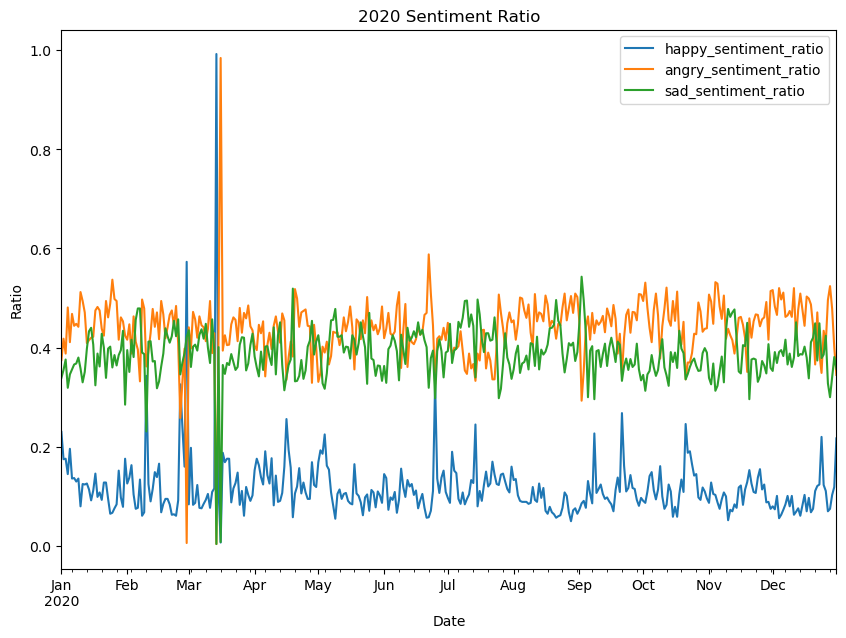

In [58]:
daily_groupby_2020['happy_sentiment_ratio'] = round((daily_groupby_2020['sentiment_happy']) / (daily_groupby_2020['sentiment_happy'] + daily_groupby_2020['sentiment_sad'] + daily_groupby_2020['sentiment_angry'] + daily_groupby_2020['sentiment_neutral']),3)
daily_groupby_2020['angry_sentiment_ratio'] = round((daily_groupby_2020['sentiment_angry']) / (daily_groupby_2020['sentiment_happy'] + daily_groupby_2020['sentiment_sad'] + daily_groupby_2020['sentiment_angry'] + daily_groupby_2020['sentiment_neutral']),3)
daily_groupby_2020['sad_sentiment_ratio'] = round((daily_groupby_2020['sentiment_sad']) / (daily_groupby_2020['sentiment_happy'] + daily_groupby_2020['sentiment_sad'] + daily_groupby_2020['sentiment_angry'] + daily_groupby_2020['sentiment_neutral']),3)
plt.figure(figsize=(3, 4))
daily_groupby_2020.plot(y=['happy_sentiment_ratio','angry_sentiment_ratio','sad_sentiment_ratio'],figsize=(10,7))
plt.title('2020 Sentiment Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

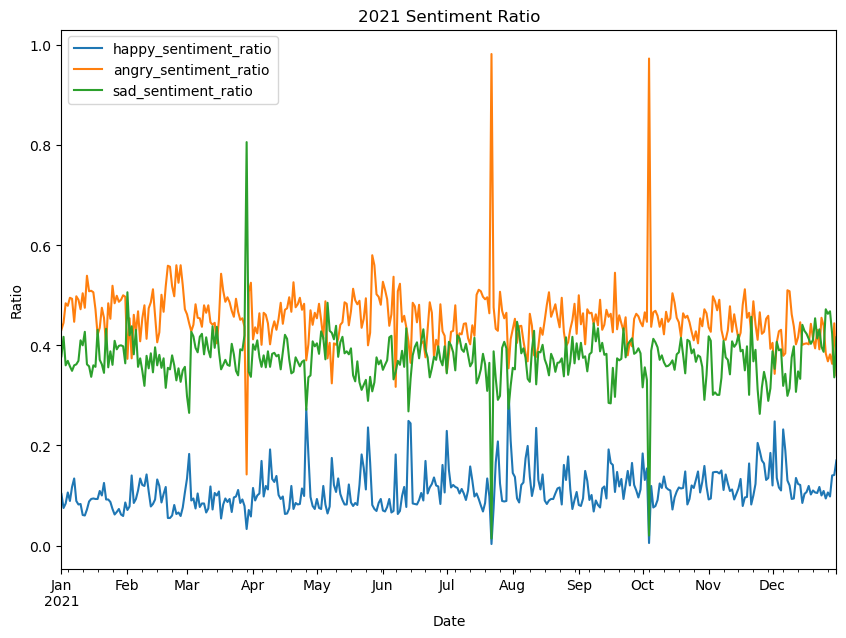

In [59]:
daily_groupby_2021['happy_sentiment_ratio'] = round((daily_groupby_2021['sentiment_happy']) / (daily_groupby_2021['sentiment_happy'] + daily_groupby_2021['sentiment_sad'] + daily_groupby_2021['sentiment_angry'] + daily_groupby_2021['sentiment_neutral']),3)
daily_groupby_2021['angry_sentiment_ratio'] = round((daily_groupby_2021['sentiment_angry']) / (daily_groupby_2021['sentiment_happy'] + daily_groupby_2021['sentiment_sad'] + daily_groupby_2021['sentiment_angry'] + daily_groupby_2021['sentiment_neutral']),3)
daily_groupby_2021['sad_sentiment_ratio'] = round((daily_groupby_2021['sentiment_sad']) / (daily_groupby_2021['sentiment_happy'] + daily_groupby_2021['sentiment_sad'] + daily_groupby_2021['sentiment_angry'] + daily_groupby_2021['sentiment_neutral']),3)
daily_groupby_2021.plot(y=['happy_sentiment_ratio','angry_sentiment_ratio','sad_sentiment_ratio'],figsize=(10,7))
plt.title('2021 Sentiment Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

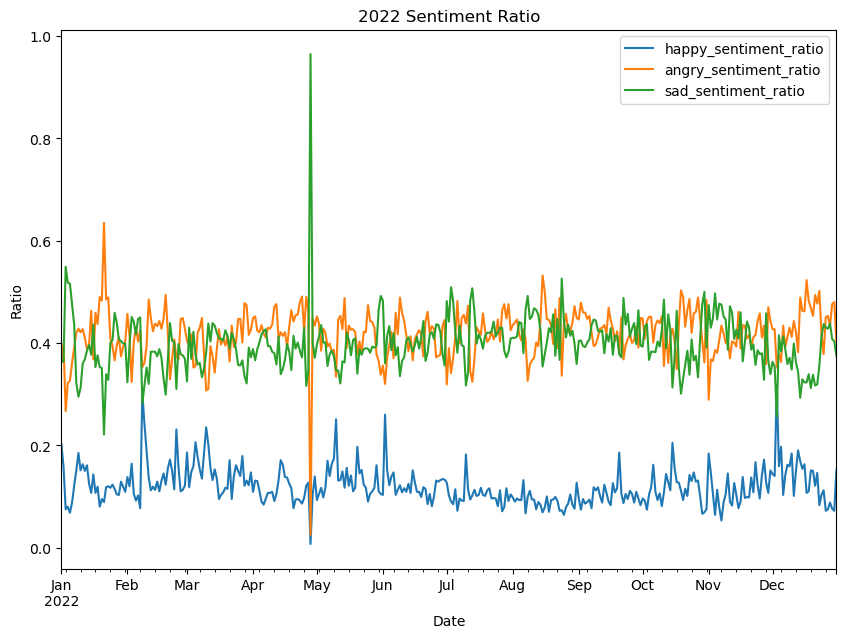

In [60]:
daily_groupby_2022['happy_sentiment_ratio'] = round((daily_groupby_2022['sentiment_happy']) / (daily_groupby_2022['sentiment_happy'] + daily_groupby_2022['sentiment_sad'] + daily_groupby_2022['sentiment_angry'] + daily_groupby_2022['sentiment_neutral']),3)
daily_groupby_2022['angry_sentiment_ratio'] = round((daily_groupby_2022['sentiment_angry']) / (daily_groupby_2022['sentiment_happy'] + daily_groupby_2022['sentiment_sad'] + daily_groupby_2022['sentiment_angry'] + daily_groupby_2022['sentiment_neutral']),3)
daily_groupby_2022['sad_sentiment_ratio'] = round((daily_groupby_2022['sentiment_sad']) / (daily_groupby_2022['sentiment_happy'] + daily_groupby_2022['sentiment_sad'] + daily_groupby_2022['sentiment_angry'] + daily_groupby_2022['sentiment_neutral']),3)
daily_groupby_2022.plot(y=['happy_sentiment_ratio','angry_sentiment_ratio','sad_sentiment_ratio'],figsize=(10,7))
plt.title('2022 Sentiment Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

- 월별 감정 칼럼

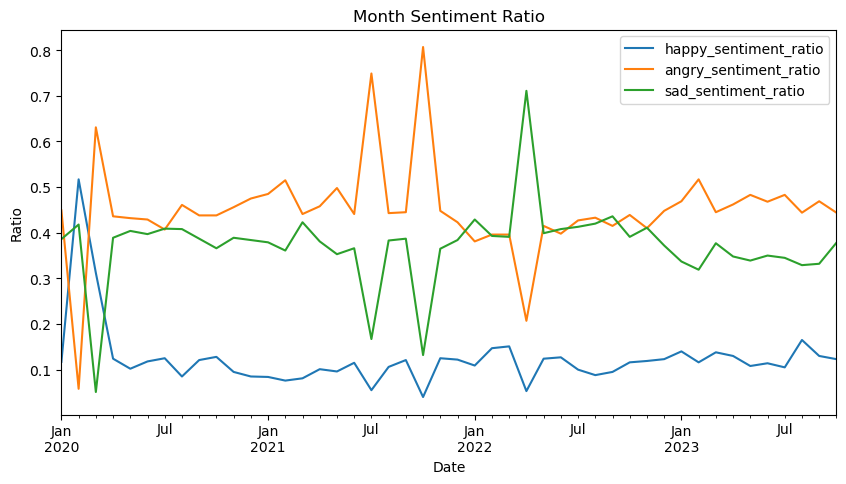

In [61]:
daily_groupby.reset_index(inplace=True)
month_groupby = daily_groupby.groupby(daily_groupby['publish_date'].dt.to_period('M')).sum()
month_groupby['happy_sentiment_ratio'] = round((month_groupby['sentiment_happy']) / (month_groupby['sentiment_happy'] + month_groupby['sentiment_sad'] + month_groupby['sentiment_angry'] + month_groupby['sentiment_neutral']),3)
month_groupby['angry_sentiment_ratio'] = round((month_groupby['sentiment_angry']) / (month_groupby['sentiment_happy'] + month_groupby['sentiment_sad'] + month_groupby['sentiment_angry'] + month_groupby['sentiment_neutral']),3)
month_groupby['sad_sentiment_ratio'] = round((month_groupby['sentiment_sad']) / (month_groupby['sentiment_happy'] + month_groupby['sentiment_sad'] + month_groupby['sentiment_angry'] + month_groupby['sentiment_neutral']),3)

month_groupby.plot(y=['happy_sentiment_ratio','angry_sentiment_ratio','sad_sentiment_ratio'],figsize=(10,5))
plt.title('Month Sentiment Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

In [62]:
# month_groupby.reset_index(inplace=True)
# daily_groupby.to_csv('../data/youtube_inference/daily_youtube_sentiment_cnt.csv',index=False)
# month_groupby.to_csv('../data/youtube_inference/monthly_youtube_sentiment_cnt.csv',index=False)

### checking inference time

In [34]:
# Configuration
BATCH_SIZE = 50 # 한번에 처리할 데이터 수
DATA_SIZE = 500 # 데이터 크기
REPETITIONS = 2 # 추론 반복 횟수
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize CUDA events for timing
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
# Time of the task (each row represents the inference time for one operation, in milliseconds (=1000*seconds))
timings = np.zeros((REPETITIONS, 1)) 
total_batch_average_time = 0
batch_li = []
temp_li = []
prediction_results = []
inference_texts = youtube_df['text'].tolist()[:DATA_SIZE]
for idx, text in enumerate(inference_texts):
    temp_li.append(text)
    if len(temp_li) == BATCH_SIZE or idx == len(inference_texts) - 1:
        batch_li.append(temp_li)
        temp_li = []

# Measure performance
for text_batch in tqdm(batch_li):
    # Tokenize and prepare input
    inference_encodings = tokenizer(text_batch, truncation=True, padding=True, return_tensors="pt")
    input_data = {key: tensor.to(device) for key, tensor in inference_encodings.items()}
    # Perform inference
    with torch.no_grad():
        for rep in range(REPETITIONS):        
            # Record start time
            starter.record() 
            model.eval()
            outputs = model(**input_data)
            ender.record()
            # Record end time 
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time
    average_time = round(np.mean(timings / 100), 2) 
total_batch_average_time += average_time
print(f'{DATA_SIZE}개 댓글 {MODEL_NAME} inference time : ', total_batch_average_time, '초')

100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

500개 댓글 roberta-large inference time :  9.18 초
